In [1]:
import os
from tqdm import tqdm
from typing import List, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport

pd.set_option("display.max_columns", 300)

/home/bocharick/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install pandas_profiling

In [3]:
os.listdir("data")

['1st_attempt',
 'train.csv',
 'applications_history.csv',
 'test_data_complete.csv',
 'payments_AFTER_EDA.csv',
 'train_data_complete.csv',
 'applications_history_AFTER_EDA.csv',
 'sample_submit.csv',
 'payments.csv',
 'bki_AFTER_EDA.csv',
 'client_profile.csv',
 'test.csv',
 'client_profile_AFTER_EDA.csv',
 'bki.csv']

# TRAIN.CSV

In [4]:
train = pd.read_csv("data/train.csv")
train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


#### APPLICATION_NUMBER
номер клиента, либо номер кредитной заявки

#### TARGET
целевая переменная, то что мы хотим спрогнозировать

#### NAME_CONTRACT_TYPE
тип контракта. какой кредитный продукт хочет клиент взять.


In [5]:
train["NAME_CONTRACT_TYPE"].value_counts()

Cash           99551
Credit Card    10542
Name: NAME_CONTRACT_TYPE, dtype: int64

# SAMPLE_SUBMIT.CSV

In [6]:
sample = pd.read_csv("data/sample_submit.csv")
sample.head(n=5)

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


#### APPLICATION_NUMBER
номер клиента, либо номер кредитной заявки

#### TARGET
целевая переменная, то что мы хотим спрогнозировать

# CLIENT_PROFILE.CSV

In [7]:
client_profile = pd.read_csv("data/client_profile.csv")
client_profile.head(n=2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
# print(*client_profile.columns, sep="\n")

#### APPLICATION_NUMBER
номер клиента, id клиента, для связи

#### GENDER
пол

#### CHILDRENS
число детей

#### TOTAL_SALARY
зарплата

#### AMOUNT_CREDIT
сумма кредита которую хочет взять

#### AMOUNT_ANNUITY
сумма ежемесячного платежа

#### EDUCATION_LEVEL
уровень образования

#### FAMILY_STATUS
семейное положение

#### REGION_POPULATION
население региона, нормализованное на какую-то величину

#### AGE
возраст, в днях

#### DAYS_ON_LAST_JOB
продолжительность работы на последнем рабочем месте, в днях

#### OWN_CAR_AGE
флаг?? наличия автомобиля

#### FLAG_PHONE
флаг подтвержденного номера телефона

#### FLAG_EMAIL
флаг подтвержденного емэйла

#### FAMILY_SIZE
размер семьи

#### EXTERNAL_SCORING_RATING_1

таргет скоринг (вероятность дефолта), оцененный другой компанией 1

#### EXTERNAL_SCORING_RATING_2
таргет скоринг (вероятность дефолта), оцененный другой компанией 2

#### EXTERNAL_SCORING_RATING_3
таргет скоринг (вероятность дефолта), оцененный другой компанией 3

#### AMT_REQ_CREDIT_BUREAU_HOUR
количество запросов сделанное в бки по данному клиенту за последний час

#### AMT_REQ_CREDIT_BUREAU_DAY
количество запросов сделанное в бки по данному клиенту за последний день

#### AMT_REQ_CREDIT_BUREAU_WEEK
количество запросов сделанное в бки по данному клиенту за последнюю неделю

#### AMT_REQ_CREDIT_BUREAU_MON
количество запросов сделанное в бки по данному клиенту за последний месяц

#### AMT_REQ_CREDIT_BUREAU_QRT
количество запросов сделанное в бки по данному клиенту за последний квартал

#### AMT_REQ_CREDIT_BUREAU_YEAR
количество запросов сделанное в бки по данному клиенту за последний год


In [9]:
client_profile["OWN_CAR_AGE"].value_counts()

7.0     6051
6.0     5199
3.0     5189
8.0     4845
2.0     4771
4.0     4525
1.0     4313
9.0     4061
10.0    3885
14.0    3721
13.0    3704
12.0    3426
11.0    3393
5.0     2906
15.0    2901
16.0    2736
17.0    2353
18.0    1969
64.0    1966
0.0     1752
19.0    1526
20.0    1233
21.0    1188
22.0    1000
24.0     929
23.0     885
65.0     711
25.0     693
26.0     461
28.0     438
27.0     406
29.0     339
30.0     267
31.0     228
32.0     170
34.0     146
35.0     124
33.0     108
36.0      97
38.0      74
40.0      70
39.0      65
37.0      59
41.0      43
42.0      39
44.0      19
43.0      15
54.0      12
45.0      10
49.0       5
55.0       4
51.0       3
46.0       3
69.0       1
56.0       1
57.0       1
47.0       1
52.0       1
Name: OWN_CAR_AGE, dtype: int64

# APPLICATIONS_HISTORY.CSV

In [10]:
apps = pd.read_csv("data/applications_history.csv")
apps.head(n=2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


#### PREV_APPLICATION_NUMBER
предыдущие заявки

#### APPLICATION_NUMBER
ключ, id клиента для связи

#### NAME_CONTRACT_TYPE
тип контракта, тоже самое что в train.csv

#### AMOUNT_ANNUITY
сумма ежемесячного платежа по предыдущему кредиту

#### AMT_APPLICATION
сумма кредита, которую он указал в заявке

#### AMOUNT_CREDIT
сумма кредита которую ему дали по факту

#### AMOUNT_PAYMENT


#### AMOUNT_GOODS_PAYMENT
стоимость товара, если это кредит на товар

#### NAME_CONTRACT_STATUS
статус заявки

#### DAYS_DECISION
сколько дней назад было принято решение по этой заявке

#### NAME_PAYMENT_TYPE
каким образом платеж будет проведен

#### CODE_REJECT_REASON
если заявка была отказная, то по ней причина отказа

#### NAME_TYPE_SUITE
каким образом заявка пришла, то есть канал привлечения

#### NAME_CLIENT_TYPE
тип клиента, уже был в базе или новый

#### NAME_GOODS_CATEGORY
категория товара, который был куплен

#### NAME_PORTFOLIO
подпродукт

#### NAME_PRODUCT_TYPE
подпродукт

#### SELLERPLACE_AREA
локация где была совершена продажа, локация офиса либо торговой точки

#### CNT_PAYMENT
количество платежей по кредиту

#### NAME_YIELD_GROUP
некоторая сегментация клиента по какому-то признаку. банки сегментируют клиентов и разным сегментам могут делать разные предложения. что-то типо кластеризации

#### DAYS_FIRST_DRAWING


#### DAYS_FIRST_DUE
сколько дней до первого платежа

#### DAYS_LAST_DUE_1ST_VERSION
сколько дней после первого платежа

#### DAYS_LAST_DUE
сколько дней после последнего платежа

#### DAYS_TERMINATION
(_ВОЗМОЖНО_) дней когда кредит был закрыт

#### NFLAG_INSURED_ON_APPROVAL
флаг, есть страховка по данному кредиту или нет


# BKI.CSV

In [11]:
bki = pd.read_csv("data/bki.csv")
bki.head(n=2)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [12]:
# print(*bki.columns, sep="\n")

#### APPLICATION_NUMBER
номер заявки, ключ

#### BUREAU_ID
какое бюро кредитных историй было опрошено

#### CREDIT_ACTIVE
статус кредита

#### CREDIT_CURRENCY
валюта, в которой был взят кредит

#### DAYS_CREDIT
какое время назад был взят кредит

#### CREDIT_DAY_OVERDUE
сколько дней просрочки

#### DAYS_CREDIT_ENDDATE
сколько дней до закрытия кредита

#### DAYS_ENDDATE_FACT
сколько дней до закрытия (тут с фактическим и планируемым мутки, типо если где-то был изменен график кредита)

#### AMT_CREDIT_MAX_OVERDUE
максимальная сумма просрочки

#### CNT_CREDIT_PROLONG
был ли пролонгирован договор

#### AMT_CREDIT_SUM
сумма кредита

#### AMT_CREDIT_SUM_DEBT
сумма средств которая была внесена

#### AMT_CREDIT_SUM_LIMIT
кредитный лимит, актуален для кредитных карт

#### AMT_CREDIT_SUM_OVERDUE
общая сумма просрочки

#### CREDIT_TYPE
тип кредита

#### DAYS_CREDIT_UPDATE
сколько дней назад было обновление информации по данному кредиту (чем более свежие данные тем больше веры им)

#### AMT_ANNUITY
сумма ежемесячного платежа


# PAYMENTS.CSV

In [13]:
payments = pd.read_csv("data/payments.csv")
payments.head(n=2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645


In [14]:
# print(*payments.columns, sep="\n")

#### PREV_APPLICATION_NUMBER
предыдущая заявка

#### APPLICATION_NUMBER
текущая заявка

#### NUM_INSTALMENT_VERSION


#### NUM_INSTALMENT_NUMBER
номер платежа

#### DAYS_INSTALMENT
сколько дней назад должен был этот платеж относительно даты подачи заявки

#### DAYS_ENTRY_PAYMENT
когда был совершен фактический платеж

#### AMT_INSTALMENT
сумма платежа по графику

#### AMT_PAYMENT
сколько клиент заплатил фактически


# TEST.CSV

In [15]:
test = pd.read_csv("data/test.csv")
test.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash


# EDA

### train.csv

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


#### С train всё ок

### client_profile.csv

In [17]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [18]:
client_profile.head(4)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0


In [19]:
"""
Отсутствующие AMOUNT_ANNUITY
Но у нас есть все AMOUNT_CREDIT. 
Значит можно взять все AMOUNT_CREDIT, поделить на соответствующие им AMOUNT_ANNUITY, получить 
средний множитель, и для отсутствующих AMOUNT_ANNUITY заполнить как AMOUNT_CREDIT поделенный на этот множитель.
"""
# tmp_client_profile = client_profile.loc[client_profile.AMOUNT_ANNUITY.notnull()]
# AVG_AMOUNT_ANNUITY_MULTIPLIER = (tmp_client_profile.AMOUNT_CREDIT / tmp_client_profile.AMOUNT_ANNUITY).mean()
# client_profile.AMOUNT_ANNUITY = client_profile.AMOUNT_ANNUITY.fillna(client_profile.AMOUNT_CREDIT / AVG_AMOUNT_ANNUITY_MULTIPLIER)

'\nОтсутствующие AMOUNT_ANNUITY\nНо у нас есть все AMOUNT_CREDIT. \nЗначит можно взять все AMOUNT_CREDIT, поделить на соответствующие им AMOUNT_ANNUITY, получить \nсредний множитель, и для отсутствующих AMOUNT_ANNUITY заполнить как AMOUNT_CREDIT поделенный на этот множитель.\n'

/home/bocharick/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bocharick/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


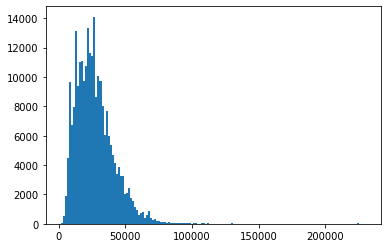

In [20]:
plt.hist(client_profile.AMOUNT_ANNUITY,bins=150)
plt.show()

In [21]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [22]:
"""
OWN_CAR_AGE
Считаем, что отсутствие значение в этой колонке означает отсутствие собственного автомобиля, и 
ставим значение в ноль.
"""
# client_profile.OWN_CAR_AGE = client_profile.OWN_CAR_AGE.fillna(0)

'\nOWN_CAR_AGE\nСчитаем, что отсутствие значение в этой колонке означает отсутствие собственного автомобиля, и \nставим значение в ноль.\n'

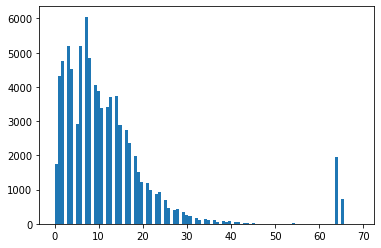

In [23]:
plt.hist(client_profile.OWN_CAR_AGE,bins=100)
plt.show()

In [24]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

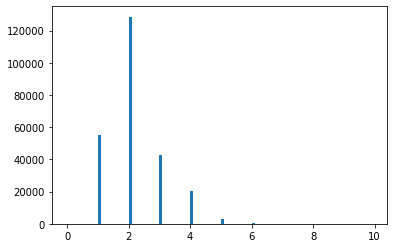

In [25]:
"""
FAMILY_SIZE
"""
plt.hist(client_profile.FAMILY_SIZE,bins=np.arange(0,10,0.1))
plt.show()


In [26]:
# client_profile.FAMILY_SIZE = client_profile.FAMILY_SIZE.fillna(2)

In [27]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [28]:
"""
EXTERNAL_SCORING_RATING_1
EXTERNAL_SCORING_RATING_2
EXTERNAL_SCORING_RATING_3
"""
client_profile.loc[(client_profile.EXTERNAL_SCORING_RATING_1.isnull()) & (client_profile.EXTERNAL_SCORING_RATING_2.isnull()) & (client_profile.EXTERNAL_SCORING_RATING_3.isnull())]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
5606,123724511,F,0,67500.0,143910.0,14364.0,Secondary / secondary special,Married,0.020246,23085,365243,NaN,1,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0
6519,123586197,F,0,122850.0,675000.0,19071.0,Secondary / secondary special,Married,0.026392,16577,297,NaN,0,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9840,123565240,F,1,157500.0,512446.5,40617.0,Higher education,Married,0.010276,16176,3458,NaN,0,0,3.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0
10010,123593914,F,0,144000.0,247275.0,17208.0,Secondary / secondary special,Married,0.007330,21723,365243,NaN,0,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,3.0
17540,123590887,F,0,180000.0,331632.0,35316.0,Higher education,Married,0.046220,8754,139,NaN,0,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241923,123642480,M,0,202500.0,490495.5,30136.5,Secondary / secondary special,Married,0.032561,10170,792,NaN,1,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
246624,123496058,F,0,51750.0,526491.0,21267.0,Secondary / secondary special,Married,0.031329,20383,365243,NaN,1,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0
247264,123471125,F,0,180000.0,422892.0,45000.0,Secondary / secondary special,Married,0.010006,18474,735,12.0,0,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0
248158,123475829,F,0,135000.0,159264.0,9270.0,Secondary / secondary special,Married,0.020713,16172,1645,NaN,0,0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
client_profile[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]]

,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,0.329471,0.236315,0.678568
1,NaN,0.442295,0.802745
2,0.409017,0.738159,NaN
3,NaN,0.308994,0.590233
4,NaN,0.739408,0.156640
...,...,...,...
249995,0.555436,0.581592,0.048259
249996,NaN,0.676409,0.726711
249997,NaN,0.353665,0.283712
249998,0.305746,0.682462,0.639708


In [30]:
client_profile_EXTERNAL_SCORING_RATING_1_AVG = client_profile.loc[client_profile.EXTERNAL_SCORING_RATING_1.notnull()].EXTERNAL_SCORING_RATING_1.mean()
client_profile_EXTERNAL_SCORING_RATING_2_AVG = client_profile.loc[client_profile.EXTERNAL_SCORING_RATING_2.notnull()].EXTERNAL_SCORING_RATING_2.mean()
client_profile_EXTERNAL_SCORING_RATING_3_AVG = client_profile.loc[client_profile.EXTERNAL_SCORING_RATING_3.notnull()].EXTERNAL_SCORING_RATING_3.mean()

In [31]:
def set_avg_row_scoring_for_nulls(row):
    score1 = row.EXTERNAL_SCORING_RATING_1
    score2 = row.EXTERNAL_SCORING_RATING_2
    score3 = row.EXTERNAL_SCORING_RATING_3
    if np.isnan(score1):
        if np.isnan(score2):
            if np.isnan(score3):
                row.EXTERNAL_SCORING_RATING_1 = client_profile_EXTERNAL_SCORING_RATING_1_AVG
                row.EXTERNAL_SCORING_RATING_2 = client_profile_EXTERNAL_SCORING_RATING_2_AVG
                row.EXTERNAL_SCORING_RATING_3 = client_profile_EXTERNAL_SCORING_RATING_3_AVG
                return row
            else:
                row.EXTERNAL_SCORING_RATING_1 = score3
                row.EXTERNAL_SCORING_RATING_2 = score3
        else:
            if np.isnan(score3):
                row.EXTERNAL_SCORING_RATING_1 = score2
                row.EXTERNAL_SCORING_RATING_3 = score2
            else:
                row.EXTERNAL_SCORING_RATING_1 = (score2 + score3) / 2.0
    else:
        if np.isnan(score2):
            if np.isnan(score3):
                row.EXTERNAL_SCORING_RATING_2 = score1
                row.EXTERNAL_SCORING_RATING_3 = score1
            else:
                row.EXTERNAL_SCORING_RATING_2 = (score1 + score3) / 2.0
        else:
            if np.isnan(score3):
                row.EXTERNAL_SCORING_RATING_3 = (score1 + score2) / 2.0
    return row

In [32]:
%%time
client_profile = client_profile.apply(set_avg_row_scoring_for_nulls, axis=1)

CPU times: user 16.8 s, sys: 210 ms, total: 17 s
Wall time: 16.5 s


In [33]:
client_profile[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]].mean()

EXTERNAL_SCORING_RATING_1    0.506666
EXTERNAL_SCORING_RATING_2    0.514233
EXTERNAL_SCORING_RATING_3    0.506813
dtype: float64

In [34]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [35]:
"""
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR
"""

# client_profile.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_HOUR.mode()), inplace=True)
# client_profile.AMT_REQ_CREDIT_BUREAU_DAY.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_DAY.mode()), inplace=True)
# client_profile.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_WEEK.mode()), inplace=True)
# client_profile.AMT_REQ_CREDIT_BUREAU_MON.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_MON.mode()), inplace=True)
# client_profile.AMT_REQ_CREDIT_BUREAU_QRT.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_QRT.mode()), inplace=True)
# client_profile.AMT_REQ_CREDIT_BUREAU_YEAR.fillna(float(client_profile.AMT_REQ_CREDIT_BUREAU_YEAR.mode()), inplace=True)

'\nAMT_REQ_CREDIT_BUREAU_HOUR\nAMT_REQ_CREDIT_BUREAU_DAY\nAMT_REQ_CREDIT_BUREAU_WEEK\nAMT_REQ_CREDIT_BUREAU_MON\nAMT_REQ_CREDIT_BUREAU_QRT\nAMT_REQ_CREDIT_BUREAU_YEAR\n'

In [80]:
client_profile.GENDER.value_counts()

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64

In [36]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

### APPLICATIONS_HISTORY.CSV

In [37]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [38]:
"""
Первое что хочется сделать это откинуть все кредиты у которых статус НЕ Approved
"""
apps = apps.loc[apps.NAME_CONTRACT_STATUS == "Approved"]

In [39]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [40]:
"""
NAME_CONTRACT_TYPE
"""
apps.NAME_CONTRACT_TYPE.value_counts()

Cash           312540
Credit Card     97771
Name: NAME_CONTRACT_TYPE, dtype: int64

##### ХЗ как, если честно, пока пропущу

In [41]:
"""
AMOUNT_ANNUITY

ща будет полет фантазии.
1) удалим единственную запись, для которой отсутствует AMOUNT_CREDIT
2) для отсутствующих значений CNT_PAYMENT выставим среднее значение
3) для отсутсвующих значений AMOUNT_ANNUITY выставим значение равное AMOUNT_CREDIT / CNT_PAYMENT
"""

# apps.dropna(subset = ["AMOUNT_CREDIT"], inplace=True)
# AVG_CNT_PAYMENT = apps.CNT_PAYMENT.mean()
# apps['CNT_PAYMENT'].fillna(AVG_CNT_PAYMENT, inplace=True)
# apps.AMOUNT_ANNUITY.fillna(apps.AMOUNT_CREDIT/apps.CNT_PAYMENT, inplace=True)

'\nAMOUNT_ANNUITY\n\nща будет полет фантазии.\n1) удалим единственную запись, для которой отсутствует AMOUNT_CREDIT\n2) для отсутствующих значений CNT_PAYMENT выставим среднее значение\n3) для отсутсвующих значений AMOUNT_ANNUITY выставим значение равное AMOUNT_CREDIT / CNT_PAYMENT\n'

In [42]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [43]:
"""
AMOUNT_PAYMENT
я считаю что это что-то типо первоначального взноса.
Поставим отсутствующие значение в 0
"""
# apps.AMOUNT_PAYMENT.fillna(0, inplace=True)

'\nAMOUNT_PAYMENT\nя считаю что это что-то типо первоначального взноса.\nПоставим отсутствующие значение в 0\n'

In [44]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [45]:
"""
AMOUNT_GOODS_PAYMENT
ставим для отсутствующих значений в размер кредита
"""
# apps.AMOUNT_GOODS_PAYMENT.fillna(apps.AMOUNT_CREDIT, inplace=True)

'\nAMOUNT_GOODS_PAYMENT\nставим для отсутствующих значений в размер кредита\n'

In [46]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [47]:
"""
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
DAYS_TERMINATION
"""
# DAYS_FIRST_DRAWING_mode = float(apps.DAYS_FIRST_DRAWING.mode())
# DAYS_FIRST_DUE_mode = float(apps.DAYS_FIRST_DUE.mode())
# DAYS_LAST_DUE_1ST_VERSION_mode = float(apps.DAYS_LAST_DUE_1ST_VERSION.mode())
# DAYS_LAST_DUE_mode = float(apps.DAYS_LAST_DUE.mode())
# DAYS_TERMINATION_mode = float(apps.DAYS_TERMINATION.mode())

# apps.DAYS_FIRST_DRAWING.fillna(DAYS_FIRST_DRAWING_mode ,inplace=True)
# apps.DAYS_FIRST_DUE.fillna(DAYS_FIRST_DUE_mode ,inplace=True)
# apps.DAYS_LAST_DUE_1ST_VERSION.fillna(DAYS_LAST_DUE_1ST_VERSION_mode ,inplace=True)
# apps.DAYS_LAST_DUE.fillna(DAYS_LAST_DUE_mode ,inplace=True)
# apps.DAYS_TERMINATION.fillna(DAYS_TERMINATION_mode ,inplace=True)

'\nDAYS_FIRST_DRAWING\nDAYS_FIRST_DUE\nDAYS_LAST_DUE_1ST_VERSION\nDAYS_LAST_DUE\nDAYS_TERMINATION\n'

In [48]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [49]:
"""
NFLAG_INSURED_ON_APPROVAL
"""
apps.NFLAG_INSURED_ON_APPROVAL.value_counts()

0.0    665527
1.0    331622
Name: NFLAG_INSURED_ON_APPROVAL, dtype: int64

# bki.csv

In [50]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [51]:
bki.sample(100)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
362570,123764291,5123049,Closed,currency 1,1118.0,0,387.0,570.0,0.00,0,258975.000,NaN,NaN,0.0,Consumer credit,565.0,NaN
522565,123731925,5827024,Closed,currency 1,818.0,0,1011.0,88.0,NaN,0,279000.000,0.0,NaN,0.0,Credit card,85.0,NaN
27216,123519289,5604218,Closed,currency 1,1149.0,0,418.0,414.0,7693.02,0,176078.385,0.0,0.0,0.0,Consumer credit,408.0,NaN
533601,123720043,5929492,Active,currency 1,672.0,0,399.0,NaN,NaN,0,117000.000,124222.5,0.0,0.0,Credit card,5.0,NaN
194838,123674101,5403865,Closed,currency 1,323.0,0,142.0,142.0,NaN,0,74893.500,0.0,NaN,0.0,Consumer credit,135.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912877,123680023,5735825,Active,currency 1,780.0,0,306.0,NaN,NaN,0,180000.000,173457.0,0.0,0.0,Credit card,147.0,NaN
248923,123515835,5167403,Active,currency 1,1101.0,0,31058.0,NaN,NaN,0,337500.000,218709.0,0.0,0.0,Credit card,8.0,NaN
743259,123589604,5723544,Active,currency 1,461.0,0,645.0,NaN,NaN,0,2632050.000,1615482.0,NaN,0.0,Car loan,5.0,0.0
329003,123684300,6759379,Active,currency 1,207.0,0,158.0,NaN,0.00,0,154350.000,83025.0,0.0,0.0,Consumer credit,23.0,NaN


In [52]:
"""
Что-то подсказывает что надо дропнуть все записи, где валюта отличается от "currency 1"
"""
bki = bki.loc[bki.CREDIT_CURRENCY == "currency 1"]

In [53]:
"""
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
если отсутствует только одно из значений то заполняем его другим.
"""
# bki.DAYS_CREDIT_ENDDATE.fillna(bki.DAYS_ENDDATE_FACT, inplace=True)
# bki.DAYS_ENDDATE_FACT.fillna(bki.DAYS_CREDIT_ENDDATE, inplace=True)

'\nDAYS_CREDIT_ENDDATE\nDAYS_ENDDATE_FACT\nесли отсутствует только одно из значений то заполняем его другим.\n'

In [54]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944492 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      944492 non-null  int64  
 1   BUREAU_ID               944492 non-null  int64  
 2   CREDIT_ACTIVE           944492 non-null  object 
 3   CREDIT_CURRENCY         944492 non-null  object 
 4   DAYS_CREDIT             944492 non-null  float64
 5   CREDIT_DAY_OVERDUE      944492 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886112 non-null  float64
 7   DAYS_ENDDATE_FACT       595627 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326394 non-null  float64
 9   CNT_CREDIT_PROLONG      944492 non-null  int64  
 10  AMT_CREDIT_SUM          944487 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     802894 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619048 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  944492 non-null  float64
 14  CREDIT_TYPE         

In [55]:
bki.DAYS_CREDIT_ENDDATE.value_counts()

7.0       870
6.0       857
3.0       846
1.0       841
4.0       822
         ... 
3916.0      1
4053.0      1
6076.0      1
5524.0      1
7031.0      1
Name: DAYS_CREDIT_ENDDATE, Length: 10273, dtype: int64

In [56]:
bki.DAYS_ENDDATE_FACT.value_counts()

350.0      461
329.0      458
84.0       458
924.0      447
322.0      444
          ... 
2847.0       1
2891.0       1
42023.0      1
2892.0       1
2893.0       1
Name: DAYS_ENDDATE_FACT, Length: 2904, dtype: int64

In [57]:
"""
AMT_CREDIT_MAX_OVERDUE
AMT_CREDIT_SUM_OVERDUE
"""
bki.AMT_CREDIT_MAX_OVERDUE.value_counts()

0.000        259790
1440.000        354
45.000          219
225.000         213
4.500           172
              ...  
3384.810          1
8170.605          1
11761.605         1
26854.245         1
18670.635         1
Name: AMT_CREDIT_MAX_OVERDUE, Length: 41395, dtype: int64

In [58]:
# bki.AMT_CREDIT_MAX_OVERDUE.fillna(bki.AMT_CREDIT_SUM_OVERDUE, inplace=True)
# bki.AMT_CREDIT_SUM_OVERDUE.fillna(bki.AMT_CREDIT_MAX_OVERDUE, inplace=True)
# bki.AMT_CREDIT_MAX_OVERDUE.fillna(0.0, inplace=True)
# bki.AMT_CREDIT_SUM_OVERDUE.fillna(0.0, inplace=True)
# # df.loc[df.my_channel > 20000, 'my_channel'] = 0
# bki.loc[bki.AMT_CREDIT_SUM_OVERDUE < bki.AMT_CREDIT_MAX_OVERDUE, "AMT_CREDIT_SUM_OVERDUE"] = bki.AMT_CREDIT_MAX_OVERDUE

In [59]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944492 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      944492 non-null  int64  
 1   BUREAU_ID               944492 non-null  int64  
 2   CREDIT_ACTIVE           944492 non-null  object 
 3   CREDIT_CURRENCY         944492 non-null  object 
 4   DAYS_CREDIT             944492 non-null  float64
 5   CREDIT_DAY_OVERDUE      944492 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886112 non-null  float64
 7   DAYS_ENDDATE_FACT       595627 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326394 non-null  float64
 9   CNT_CREDIT_PROLONG      944492 non-null  int64  
 10  AMT_CREDIT_SUM          944487 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     802894 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619048 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  944492 non-null  float64
 14  CREDIT_TYPE         

In [60]:
"""
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
"""
# bki.AMT_CREDIT_SUM.fillna(bki.AMT_CREDIT_SUM_DEBT, inplace=True)
# bki.AMT_CREDIT_SUM_DEBT.fillna(bki.AMT_CREDIT_SUM, inplace=True)


'\nAMT_CREDIT_SUM\nAMT_CREDIT_SUM_DEBT\n'

In [61]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944492 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      944492 non-null  int64  
 1   BUREAU_ID               944492 non-null  int64  
 2   CREDIT_ACTIVE           944492 non-null  object 
 3   CREDIT_CURRENCY         944492 non-null  object 
 4   DAYS_CREDIT             944492 non-null  float64
 5   CREDIT_DAY_OVERDUE      944492 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886112 non-null  float64
 7   DAYS_ENDDATE_FACT       595627 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326394 non-null  float64
 9   CNT_CREDIT_PROLONG      944492 non-null  int64  
 10  AMT_CREDIT_SUM          944487 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     802894 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619048 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  944492 non-null  float64
 14  CREDIT_TYPE         

In [62]:
"""
AMT_CREDIT_SUM_LIMIT
"""
# bki.AMT_CREDIT_SUM_LIMIT.value_counts()
# bki.AMT_CREDIT_SUM_LIMIT.fillna(0.0, inplace=True)

'\nAMT_CREDIT_SUM_LIMIT\n'

In [63]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944492 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      944492 non-null  int64  
 1   BUREAU_ID               944492 non-null  int64  
 2   CREDIT_ACTIVE           944492 non-null  object 
 3   CREDIT_CURRENCY         944492 non-null  object 
 4   DAYS_CREDIT             944492 non-null  float64
 5   CREDIT_DAY_OVERDUE      944492 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886112 non-null  float64
 7   DAYS_ENDDATE_FACT       595627 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326394 non-null  float64
 9   CNT_CREDIT_PROLONG      944492 non-null  int64  
 10  AMT_CREDIT_SUM          944487 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     802894 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619048 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  944492 non-null  float64
 14  CREDIT_TYPE         

In [64]:
"""
AMT_ANNUITY
"""
bki.AMT_ANNUITY.value_counts()

0.000        141413
4500.000       2821
13500.000      1771
22500.000      1342
9000.000        945
              ...  
69939.000         1
24518.745         1
7096.275          1
69961.500         1
55674.000         1
Name: AMT_ANNUITY, Length: 29445, dtype: int64

In [65]:
bki.loc[bki.AMT_ANNUITY.isnull()]

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.810,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.000,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN
6,123485602,6672860,Closed,currency 1,910.0,0,12933.0,699.0,NaN,0,90000.00,0.000,0.0,0.0,Credit card,688.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945228,123440606,6152073,Closed,currency 1,272.0,0,180.0,180.0,265.590,0,36450.00,0.000,0.0,0.0,Consumer credit,177.0,NaN
945229,123673441,5235365,Closed,currency 1,2759.0,0,1298.0,1834.0,NaN,0,332725.50,0.000,NaN,0.0,Consumer credit,1707.0,NaN
945230,123539211,5899696,Active,currency 1,359.0,0,1467.0,NaN,NaN,0,1471500.00,1320183.000,0.0,0.0,Consumer credit,47.0,NaN
945231,123686333,5445504,Closed,currency 1,1102.0,0,725.0,370.0,NaN,0,112500.00,0.000,0.0,0.0,Consumer credit,233.0,NaN


# payments.csv

In [66]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [67]:
payments.sample(100)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
423941,49356976,123764570,1.0,5,1110.0,1118.0,5942.790,5942.790
718759,49014760,123573544,1.0,1,438.0,449.0,42631.650,42631.650
154228,48842558,123593404,0.0,55,222.0,225.0,23409.540,23409.540
100929,48525923,123779453,0.0,57,1048.0,1048.0,160.830,160.830
207775,48787677,123732751,1.0,3,2562.0,2570.0,10662.390,10662.390
...,...,...,...,...,...,...,...,...
97156,48385734,123516367,1.0,8,2491.0,2492.0,7869.015,7869.015
697743,49873294,123594863,1.0,6,2249.0,2268.0,5021.685,5021.685
266110,49427284,123702399,2.0,3,871.0,877.0,687735.495,687735.495
633656,48936860,123536373,1.0,15,2218.0,2217.0,1962.855,1962.855


In [68]:
"""
DAYS_ENTRY_PAYMENT
"""
# payments.DAYS_ENTRY_PAYMENT.fillna(payments.DAYS_INSTALMENT, inplace=True)

'\nDAYS_ENTRY_PAYMENT\n'

In [69]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [70]:
"""
AMT_PAYMENT
"""
# payments.AMT_PAYMENT.fillna(payments.AMT_INSTALMENT, inplace=True)

'\nAMT_PAYMENT\n'

In [71]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


# SAVE DATA AFTER EDA

In [72]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [73]:
client_profile.to_csv("data/client_profile_AFTER_EDA.csv", index=False)

In [74]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036781 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1036781 non-null  int64  
 1   APPLICATION_NUMBER         1036781 non-null  int64  
 2   NAME_CONTRACT_TYPE         410311 non-null   object 
 3   AMOUNT_ANNUITY             1036773 non-null  float64
 4   AMT_APPLICATION            1036781 non-null  float64
 5   AMOUNT_CREDIT              1036780 non-null  float64
 6   AMOUNT_PAYMENT             662381 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       993946 non-null   float64
 8   NAME_CONTRACT_STATUS       1036781 non-null  object 
 9   DAYS_DECISION              1036781 non-null  int64  
 10  NAME_PAYMENT_TYPE          1036781 non-null  object 
 11  CODE_REJECT_REASON         1036781 non-null  object 
 12  NAME_TYPE_SUITE            664337 non-null   object 
 13  NAME_CLIENT_

In [75]:
apps.to_csv("data/applications_history_AFTER_EDA.csv", index=False)

In [76]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944492 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      944492 non-null  int64  
 1   BUREAU_ID               944492 non-null  int64  
 2   CREDIT_ACTIVE           944492 non-null  object 
 3   CREDIT_CURRENCY         944492 non-null  object 
 4   DAYS_CREDIT             944492 non-null  float64
 5   CREDIT_DAY_OVERDUE      944492 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886112 non-null  float64
 7   DAYS_ENDDATE_FACT       595627 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326394 non-null  float64
 9   CNT_CREDIT_PROLONG      944492 non-null  int64  
 10  AMT_CREDIT_SUM          944487 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     802894 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619048 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  944492 non-null  float64
 14  CREDIT_TYPE         

In [77]:
bki.to_csv("data/bki_AFTER_EDA.csv", index=False)

In [78]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [79]:
payments.to_csv("data/payments_AFTER_EDA.csv", index=False)